In [1]:
from os.path import join
import pandas as pd
import numpy as np
import gzip
import simplejson
import json
import time
import scipy.spatial
import pickle

from sklearn.feature_extraction import DictVectorizer
from keras.preprocessing.text import text_to_word_sequence

Using TensorFlow backend.
/home/michael/Documents/deep_learning/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
# utils
def initEmbeddingMap(fileName):
    with open(join("data", "glove.6B", fileName)) as glove:
        return {l[0]: np.asarray(l[1:], dtype="float32") for l in [line.split() for line in glove]}

def clean(text):
    return text_to_word_sequence(text, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                                 lower=True, split=" ")


# returns dict with users and movies they rated as repeated rows
# cleans review text and add to rawOutput
def initRawData(input_file, save=False):
    print('initializing raw data')
    rawInputData = []
    rawOutputData = []
    with open(input_file,'r') as f:
        for i in f:
            line = f.readline()
            if len(line) < 4:
                break
            lineObj = json.loads(line)
            user = lineObj['reviewerID']
            item = lineObj['asin']
            rawInputDataObj = {'user':user, 'asin':item}
            rawOutputDataObj = clean(lineObj['reviewText'])
            rawInputData.append(rawInputDataObj)
            rawOutputData.append(rawOutputDataObj)
#     if save:
#         pickle.dump((rawInputData, rawOutputData), open(fileName,'wb'))
    return rawInputData, rawOutputData

# creates dict of usrs w/ all movies rated + movies w/ all user ratings *** 
def group_data(inputData):
    users = {}
    items = {}
    for datum in inputData:
        u = datum['user']
        i = datum['asin']
        users.setdefault(u, []).append(i)
        items.setdefault(i, []).append(u)
    return (users, items)

def getSetFromData(key, data):
    result = set()
    for datum in data:
        result.add(datum.get(key))
    return result

def seq_2_matrix(sequence, embedding_map):
    m = []
    for word in sequence:
        emb = embedding_map.get(word)
        if emb is not None:
            m.append(emb)
    return np.array(m)

def matrix_2_avg(emb_matrix):
    return np.mean(emb_matrix, 0)


# utils - one hot encodes all data 
def initVecData(rawInputData, rawOutputData, embedding_map):
    print('initializing vectorized data')
    dictVect = DictVectorizer()
    vecInputData = dictVect.fit_transform(rawInputData).toarray()
    vecOutputData = [matrix_2_avg(seq_2_matrix(review, embedding_map)) for review in rawOutputData]
    return vecInputData, vecOutputData

def initMatInputData(rawInputData, rawOutputData, embedding_map, save=False):
    print('initializing matrix data')
    if len(rawInputData) != len(rawOutputData):
        raise ValueError("Need same size of input and output")
    users = {}
    extra_info = {}
    items = {}
    dictVect = DictVectorizer()
    for i in range(len(rawInputData)):
        vecOutput = seq_2_matrix(rawOutputData[i], embedding_map)
        rawInput = rawInputData[i]
        user = rawInput['user']
        item = rawInput['asin']
        users.setdefault(user, []).append(vecOutput)
        items.setdefault(item, []).append(vecOutput)
        
    matUserInputData = []
    matItemInputData = []
    users = {k: np.vstack(v) for k, v in users.items()}
    items = {k: np.vstack(v) for k, v in items.items()}
    extra_info['user_seq_sizes'] = [m.shape[0] for m in users.values()]
    extra_info['item_seq_sizes'] = [m.shape[0] for m in items.values()]
    for i in range(len(rawInputData)):
        rawInput = rawInputData[i]
        user = rawInput['user']
        item = rawInput['asin']
        matUserInputData.append(users.get(user))
        matItemInputData.append(items.get(item))
    return matUserInputData, matItemInputData, extra_info

def toKey(user, item):
    return (user, item)

def initRatingsOutputData(rawInputData, input_file, save=False):
    ratingsData = []
    userItemDict = {}
    for i in range(len(rawInputData)):
        rawInput = rawInputData[i]
        userItem = toKey(rawInput['user'], rawInput['asin'])
        userItemDict[userItem] = i
        ratingsData.append(None) # check later to make sure no Nones left
        
    with open(input_file,'r') as f:
        for i in f:
            line = f.readline()
            lineObj = json.loads(line)
            user = lineObj['reviewerID']
            item = lineObj['asin']
            rating = lineObj['overall']
            i = userItemDict.get(toKey(user, item))
            if i is not None:
                ratingsData[i] = rating
        failure = None in ratingsData
        if failure:
            raise ValueError(str(len([r for r in ratingsData if r is None])) + " reviews did not have corresponding rating.")
    return ratingsData

# Text Preprocessing Examples

**_initRawData( )_** - returns rawInputData and rawOutputData.

**_rawInputData:_** List of dicts where each dict is a userID and movieID grouping. Groupings are unqiue but a user 
or movie can/do repeat if multiple users have reviewed a particular movie
    
**_rawOutputData:_** List of lists where each sub list is text from a unique review. The reviews correspond to the
user/movie key pairs in rawInputData

In [42]:
fileName = "data/reviews_Amazon_Instant_Video_5.json"
rawInputData, rawOutputData = initRawData(input_file=fileName, save=False)
print("Number of user/item data:", len(rawInputData))
print("Number of reviews:", len(rawOutputData))
print()
print(rawInputData[0:5])
print()
print(rawOutputData[0])
print()
print(rawOutputData[1])

initializing raw data
Number of user/item data: 18563
Number of reviews: 18563

[{'user': 'A3BC8O2KCL29V2', 'asin': 'B000H00VBQ'}, {'user': 'A1RJPIGRSNX4PW', 'asin': 'B000H00VBQ'}, {'user': 'A1POFVVXUZR3IQ', 'asin': 'B000H00VBQ'}, {'user': 'ATASGS8HZHGIB', 'asin': 'B000H0X79O'}, {'user': 'AUX8EUBNTHIIU', 'asin': 'B000H0X79O'}]

['i', 'highly', 'recommend', 'this', 'series', 'it', 'is', 'a', 'must', 'for', 'anyone', 'who', 'is', 'yearning', 'to', 'watch', 'grown', 'up', 'television', 'complex', 'characters', 'and', 'plots', 'to', 'keep', 'one', 'totally', 'involved', 'thank', 'you', 'amazin', 'prime']

['mysteries', 'are', 'interesting', 'the', 'tension', 'between', 'robson', 'and', 'the', 'tall', 'blond', 'is', 'good', 'but', 'not', 'always', 'believable', 'she', 'often', 'seemed', 'uncomfortable']


**_group-data( )_** - returns dicts of userID/movieID and movieID/userID groups

**_users:_** Dict where each userID key has a corresponding list of movieID they've' reviewed
    
**_movies:_** Dict where each movieID key has all the userIDs of reviews

In [9]:
users, movies = group_data(rawInputData)
print("All movies userID 'A3BC8O2KCL29V2' has seen:\n", users['A3BC8O2KCL29V2'])
print()
print("All userIDs of watches of movie 'B00F0CLHQO':\n", movies['B00F0CLHQO'])
print()
print("Number of movies:", len(movies))
print("Number of users:", len(users))

All movies userID 'A3BC8O2KCL29V2' has seen:
 ['B000H00VBQ', 'B00F0CLHQO', 'B00I3MMN4I']

All userIDs of watches of movie 'B00F0CLHQO':
 ['A3BC8O2KCL29V2', 'A821GRKOLGILD', 'AGTOYPUYZCCWN', 'AXO4PQU0XG3TG', 'A2LCOSYZL96HHA', 'A328S9RN3U5M68', 'AGUN5F2W85777', 'A1WXOTZHDNAV0Q', 'A3QLAOOTFEHCJI', 'A1TPW86OHXTXFC', 'AFVHO52P7IMPG', 'A18758S1PUYIDT']

Number of movies: 1685
Number of users: 5033


**Randomize the data**

In [10]:
rand_idxs = np.random.permutation(len(rawOutputData))
print("Randomized index list:", rand_idxs)
print("Total number of rand_indxs:", len(rand_idxs))
rawInputData = [rawInputData[i] for i in rand_idxs]
rawOutputData = [rawOutputData[i] for i in rand_idxs]

Randomized index list: [ 3045  1189 14159 ..., 14178  2385 14048]
Total number of rand_indxs: 18563


**Get Embedding Matrix **

Uses GloVe 50d (100d, 300d) pre-trained embedding to create a giant word dict of possible words.
We then use this matrix to create encodings of movie reviews 

__requires__: GloVe Embeddings to be downloaded - http://nlp.stanford.edu/data/glove.6B.zip

In [7]:
embedding_map = initEmbeddingMap("glove.6B.50d.txt")

NameError: name 'join' is not defined

**_getSetFromData( )_**: Gets list of unique userID or unique movieID from data

**_initVecData( )_**: Returns vectorized versions _InputData_ and dense encodings of review text using embedding matrix

**_vecInputData_**: 
Is rawInputData dict of 18563 samples of userID to movieID, converted to one-hot encoding of where first 5033 col represent user encodings and remaining represent 1685 movieIDs

**_vecOutputData_**: 
Is rawOutputData list of reviews seperated into words where each 
word in the review is swapped for it's embedding representation i.e.
1x50 row per word. These rows are turn into a matrix of words x 50 dims
then you take mean of each col to get a 1x50 array (why?). These arrays
are returned for each  18563 sample yielding a 18563x50 list matrix

In [15]:
all_users = getSetFromData('user', rawInputData)
all_movies = getSetFromData('asin', rawInputData)
vecInputData, vecOutputData = initVecData(rawInputData, rawOutputData, embedding_map)

print("Shape of matrix vecInputData: {}".format(vecInputData.shape))
print("Shape of list vecOutputData: ({}, {})".format(len(vecOutputData), len(vecOutputData[0])))


initializing vectorized data
Shape of matrix vecInputData: (18563, 6718)
Shape of list vecOutputData: (18563, 50)


In [16]:
vecInputData.shape

(18563, 6718)

**_initMatInputData_**: Creates dense encodings UserID/MovieID data and text review data

In [17]:
matUserInputData, matMovieInputData, extra_info = initMatInputData(rawInputData, rawOutputData, embedding_map)
#print(len(matUserInputData))
#print(len(matMovieInputData))
print(matUserInputData[0:1])
print()



initializing matrix data
[array([[ 0.47670999, -0.11237   , -0.79111999, ...,  0.26365   ,
         0.35497001,  1.17120004],
       [ 0.26818001,  0.14346001, -0.27877   , ..., -0.63209999,
        -0.25027999, -0.38097   ],
       [-0.23763999,  0.43119001, -0.72153997, ..., -0.47773999,
         0.37379   ,  1.07819998],
       ..., 
       [ 0.58858001,  0.11023   ,  0.23232   , ..., -0.16658001,
        -0.12446   , -0.12803   ],
       [ 0.32111999, -0.69305998,  0.47922   , ..., -0.43547001,
        -0.1108    , -0.58499998],
       [ 0.68491   ,  0.32385001, -0.11592   , ...,  0.17873999,
        -0.1693    ,  0.062375  ]], dtype=float32)]



In [18]:
print(matMovieInputData[5].shape)
matMovieInputData[5]

(2029, 50)


array([[ 0.11891   ,  0.15255   , -0.082073  , ..., -0.57511997,
        -0.26671001,  0.92120999],
       [-0.28663   , -0.10575   , -0.34178001, ..., -0.29330999,
        -0.26267001,  0.91096002],
       [ 0.81493998, -0.14850999,  0.18385001, ...,  1.18729997,
        -0.90315002,  0.47567999],
       ..., 
       [ 0.16163   ,  0.78637999, -0.50019002, ...,  0.45570999,
        -0.44395   ,  0.68005002],
       [ 0.68046999, -0.039263  ,  0.30186   , ..., -0.073297  ,
        -0.064699  , -0.26043999],
       [ 0.062712  , -0.0039197 ,  0.23992001, ..., -0.58393002,
        -0.32018   ,  0.39699   ]], dtype=float32)

**_initRatingsOutputData( )_**: 
Index each unique key pair (usr/movie) in rawInputData then assigns the correct
rating to the ratings list based on that index of the key pair in dict userItemDict.
Returns list of scores ordered correctly



In [19]:
fileName = "data/reviews_Amazon_Instant_Video_5.json"
ratingsData = initRatingsOutputData(rawInputData, input_file=fileName,save=False)

print("Printing a few ratings...\n", ratingsData[0:20])
print()
print("Total ratings:", len(ratingsData))


Printing a few ratings...
 [5.0, 3.0, 3.0, 5.0, 5.0, 3.0, 5.0, 1.0, 5.0, 2.0, 5.0, 3.0, 1.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0]

Total ratings: 18563


# DeepCoNN Recommendation Model

In [37]:
import matplotlib.pyplot as plt  
%matplotlib inline

from keras.models import Model
from keras.layers import Input, Dense
from keras.layers.merge import Dot
from keras.callbacks import EarlyStopping
from keras import metrics
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers.merge import Add, Dot, Concatenate
from keras.preprocessing.sequence import pad_sequences

In [22]:
class DeepCoNN():
    def __init__(self, embedding_size, hidden_size, u_seq_len, m_seq_len, filters=2, kernel_size=8, strides=6):
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.filters = filters
        self.kernel_size = kernel_size
        self.inputU, self.towerU = self.create_deepconn_tower(u_seq_len)
        self.inputM, self.towerM = self.create_deepconn_tower(m_seq_len)
        self.joined = Concatenate()([self.towerU, self.towerM])
        self.outNeuron = Dense(1)(self.joined)

    def create_deepconn_tower(self, max_seq_len):
        input_layer = Input(shape=(max_seq_len, self.embedding_size))
        tower = Conv1D(filters=self.filters, kernel_size=self.kernel_size, activation="relu")(input_layer)
        tower = MaxPooling1D()(tower)
        tower = Flatten()(tower)
        tower = Dense(self.hidden_size, activation="relu")(tower)
        return input_layer, tower

    def create_deepconn_dp(self):
        dotproduct = Dot(axes=1)([self.towerU, self.towerM])
        output = Add()([self.outNeuron, dotproduct])
        model = Model(inputs=[self.inputU, self.inputM], outputs=[output])
        model.compile(optimizer='Adam', loss='mse')
        return model

In [30]:
def build_DeepcoNN(matUserInputData, matItemInputData, ratingsData, u_seq_len=200, i_seq_len=200, hidden_size=4, epochs=3500, training=None):
    embed_dims = matUserInputData[0].shape[1]
    deepconn = DeepCoNN(embed_dims, hidden_size, u_seq_len, i_seq_len)

    model = deepconn.create_deepconn_dp()

    user_input = pad_sequences(np.asarray(matUserInputData), maxlen=u_seq_len)
    item_input = pad_sequences(np.asarray(matItemInputData), maxlen=i_seq_len)

    trainingN = int(len(user_input) * training) if type(training) is float else training

    inputs = [user_input, item_input]
    outputs = np.asarray(ratingsData)
    print(model.summary())

    train_inputs = [user_input[:trainingN], item_input[:trainingN]]
    train_outputs = outputs[:trainingN]
    test_inputs = [user_input[trainingN:], item_input[trainingN:]]
    test_outputs = outputs[trainingN:]

    early_stopping = EarlyStopping(monitor='loss', patience=4)
    early_stopping_val = EarlyStopping(monitor='val_loss', patience=6)
    batch_size = 32
    history = model.fit(train_inputs, train_outputs, validation_split=0.2, callbacks=[early_stopping, early_stopping_val], batch_size=batch_size, epochs=epochs)
    return history

In [24]:
# Calculates median user review length and item length. We then pad each review to these numbers
ptile = 50
u_seq_len = int(np.percentile(np.array(extra_info['user_seq_sizes']), ptile))
i_seq_len = int(np.percentile(np.array(extra_info['item_seq_sizes']), ptile))
print(u_seq_len)
print(i_seq_len)


141
474


#### Pour some sugar on meeee....

In [31]:
history = build_DeepcoNN(matUserInputData, matMovieInputData, ratingsData, 
               u_seq_len=u_seq_len, i_seq_len=i_seq_len, hidden_size=4, 
               epochs=2, training=None)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 141, 50)      0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 474, 50)      0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 134, 2)       802         input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 467, 2)       802         input_12[0][0]                   
__________________________________________________________________________________________________
max_poolin

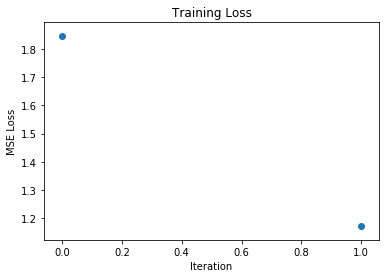

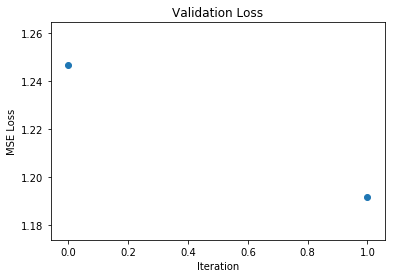

In [40]:
loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.scatter(x=range(len(loss)), y=loss)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.show()
plt.scatter(x=range(len(validation_loss)), y=validation_loss)
plt.title("Validation Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.show()